In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from PIL import Image, ImageDraw

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512

In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def load_model(model_path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    print('Successfully Load Model: ', os.path.basename(model_path))
    return model

In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()
# def get_weights(model):
#     conv_layers_weights = dict()
#     for name, param in model.named_parameters():
# #         print(name,param.shape)
#         conv_layers_weights[name] = param
#         if name == 'module.mask':
#             return param
        
def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     return model.module.lmask.mask

In [6]:
def predict_model(PATH, title):
    model = load_model(PATH)
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #forward
        outputs, reg = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)
        # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
        # print ('group loss:',group_loss[0])
        y = labels.data
        batch_size = labels.data.shape[0]
        # print(y.resize_(batch_size,1))
        running_corrects += torch.sum(preds == y)
        # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
        epoch_acc = float(running_corrects) /dataset_sizes[phase]
        true_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    
    #Draw weights
    weights = get_weights(model)
    weights = weights.cpu().detach().numpy()
    weights = np.transpose(weights)
    print(weights.shape)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    im = ax.imshow(weights,cmap=plt.cm.jet)
    plt.colorbar(im,orientation='vertical')
    plt.title(title)
    plt.show()
    return true_labels, model_preds

In [7]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
def plot_confusion_matrix_and_text(cm, labels_name, title):
    plt.figure(figsize=(16,16),dpi=200)
    plt.subplot(221)
    plot_confusion_matrix(cm, labels_name, title)
    plt.subplot(222)
    
    text_img = Image.new('RGB', (350, 250), color = (255,255,255))
    d = ImageDraw.Draw(text_img)
    text_content = classification_report(true_labels, model_preds, target_names=labels_name)
    d.text((0,0), text_content, fill=(0,0,0))
    plt.imshow(text_img)
    plt.show()

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7907
(10, 64)


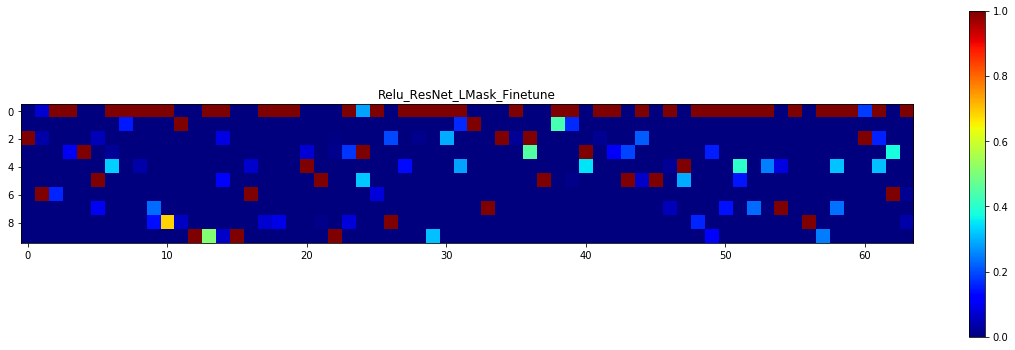

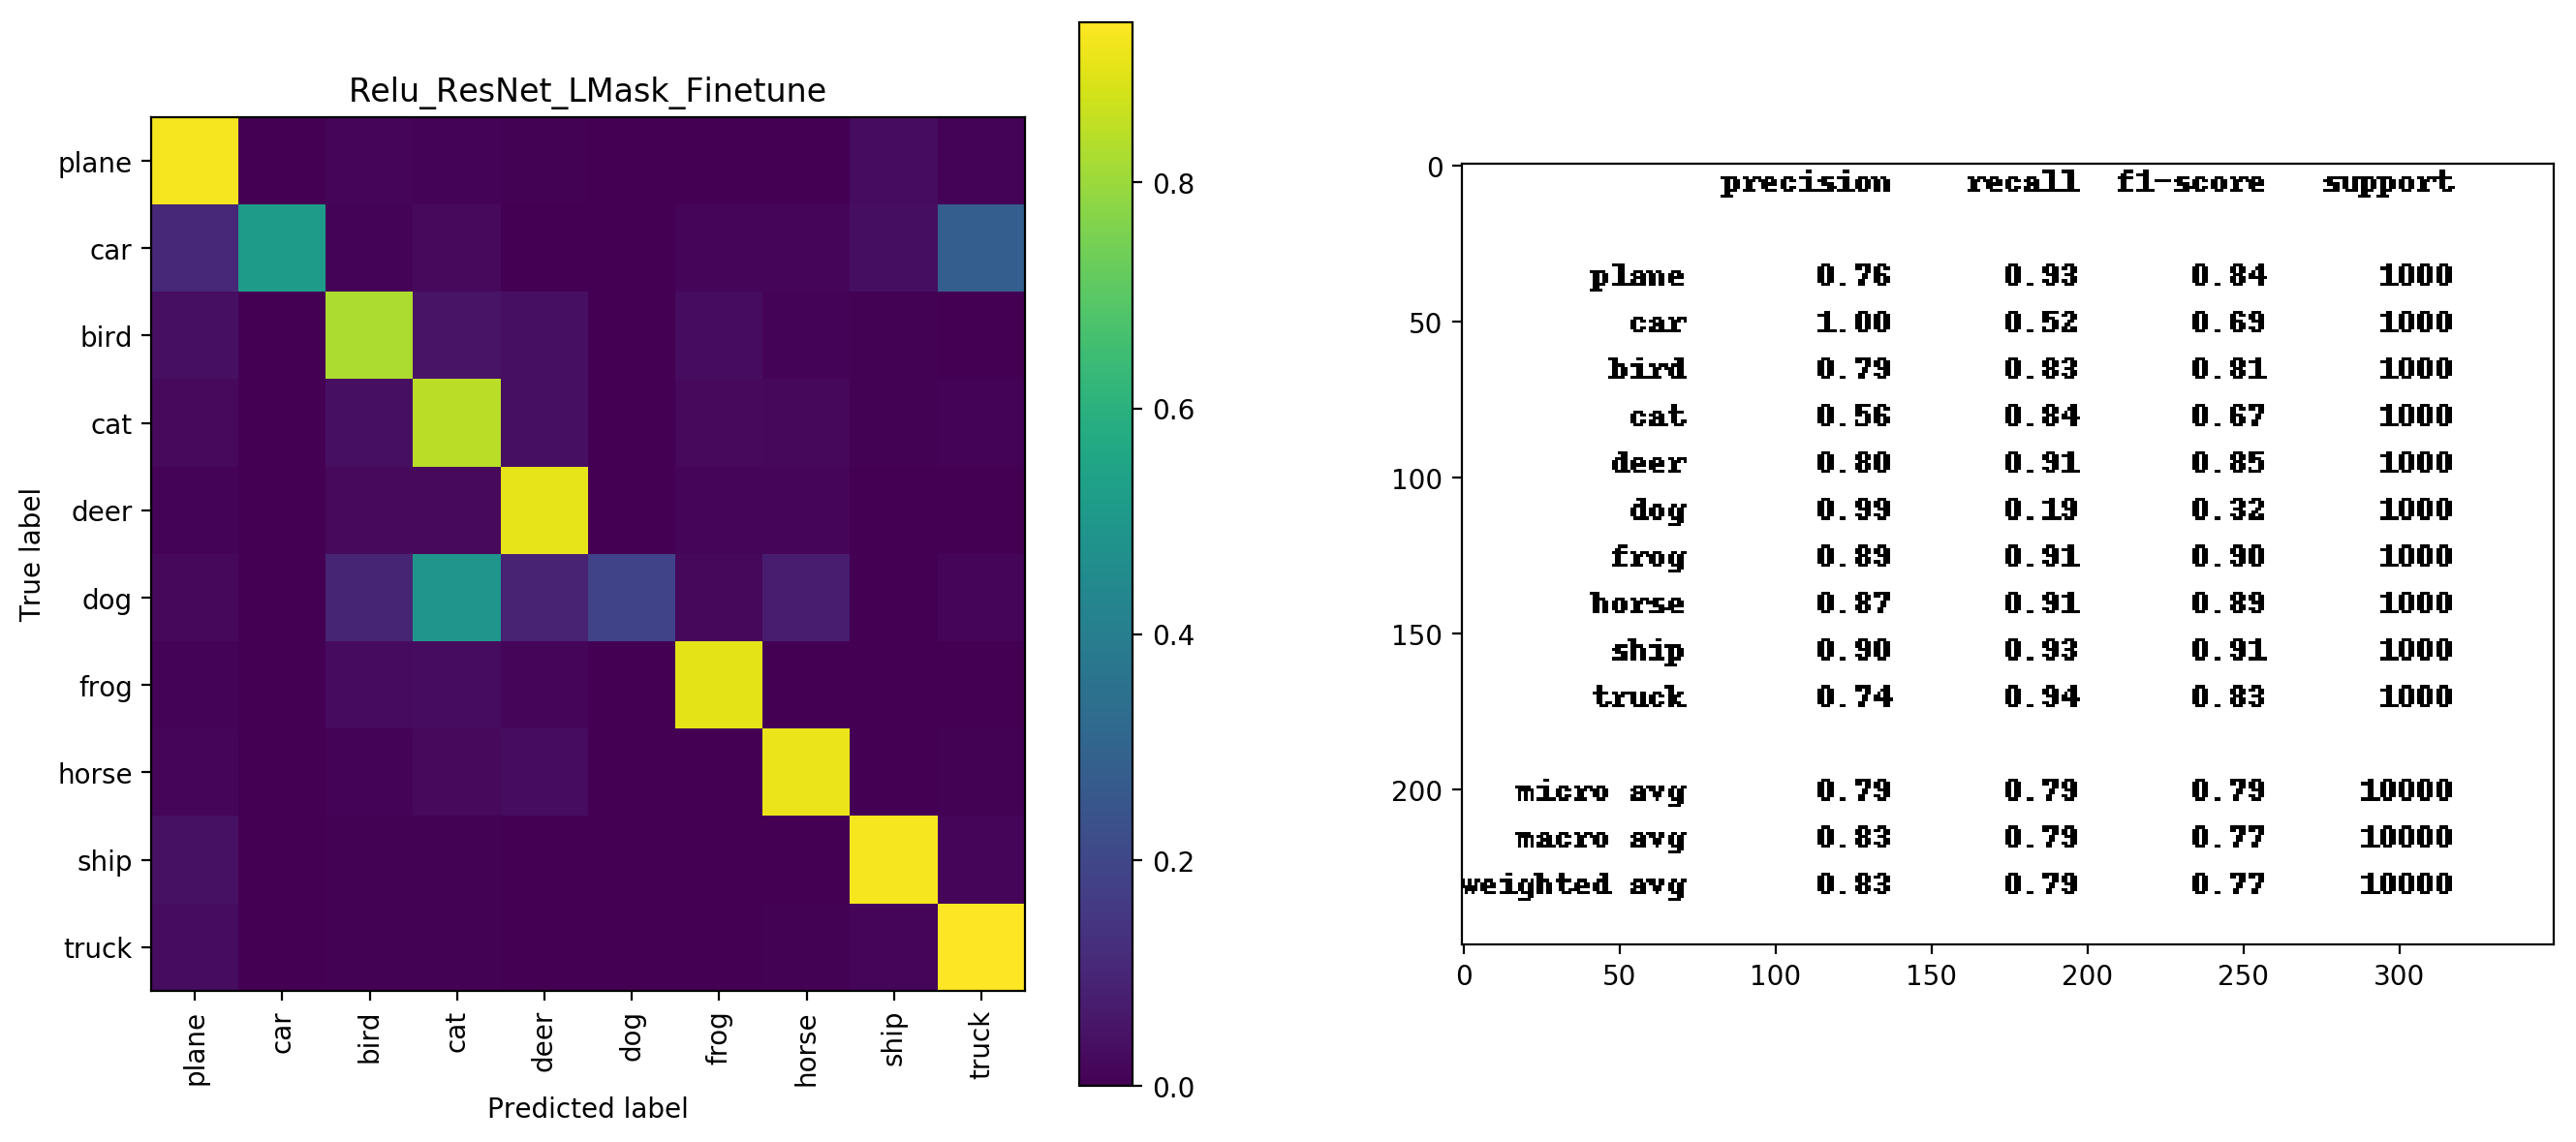

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,929,0,13,9,5,0,3,0,31,10
1,104,521,9,25,1,0,12,13,34,281
2,38,0,826,51,37,0,33,8,6,1
3,23,0,37,844,39,1,23,19,5,9
4,9,0,25,23,908,0,17,14,3,1
5,21,0,96,491,89,190,21,74,3,15
6,10,0,29,32,17,0,905,1,3,3
7,12,0,8,25,31,0,2,913,3,6
8,44,0,5,4,1,0,3,2,929,12
9,30,0,4,4,0,0,1,5,14,942


In [8]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Finetune'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7373
(10, 64)


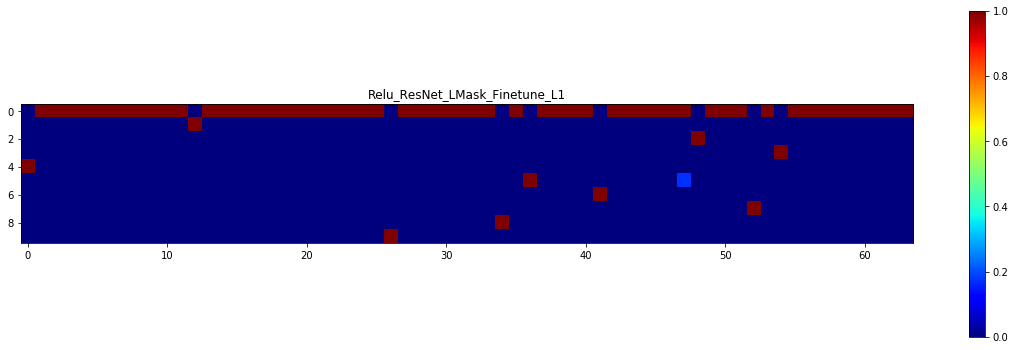

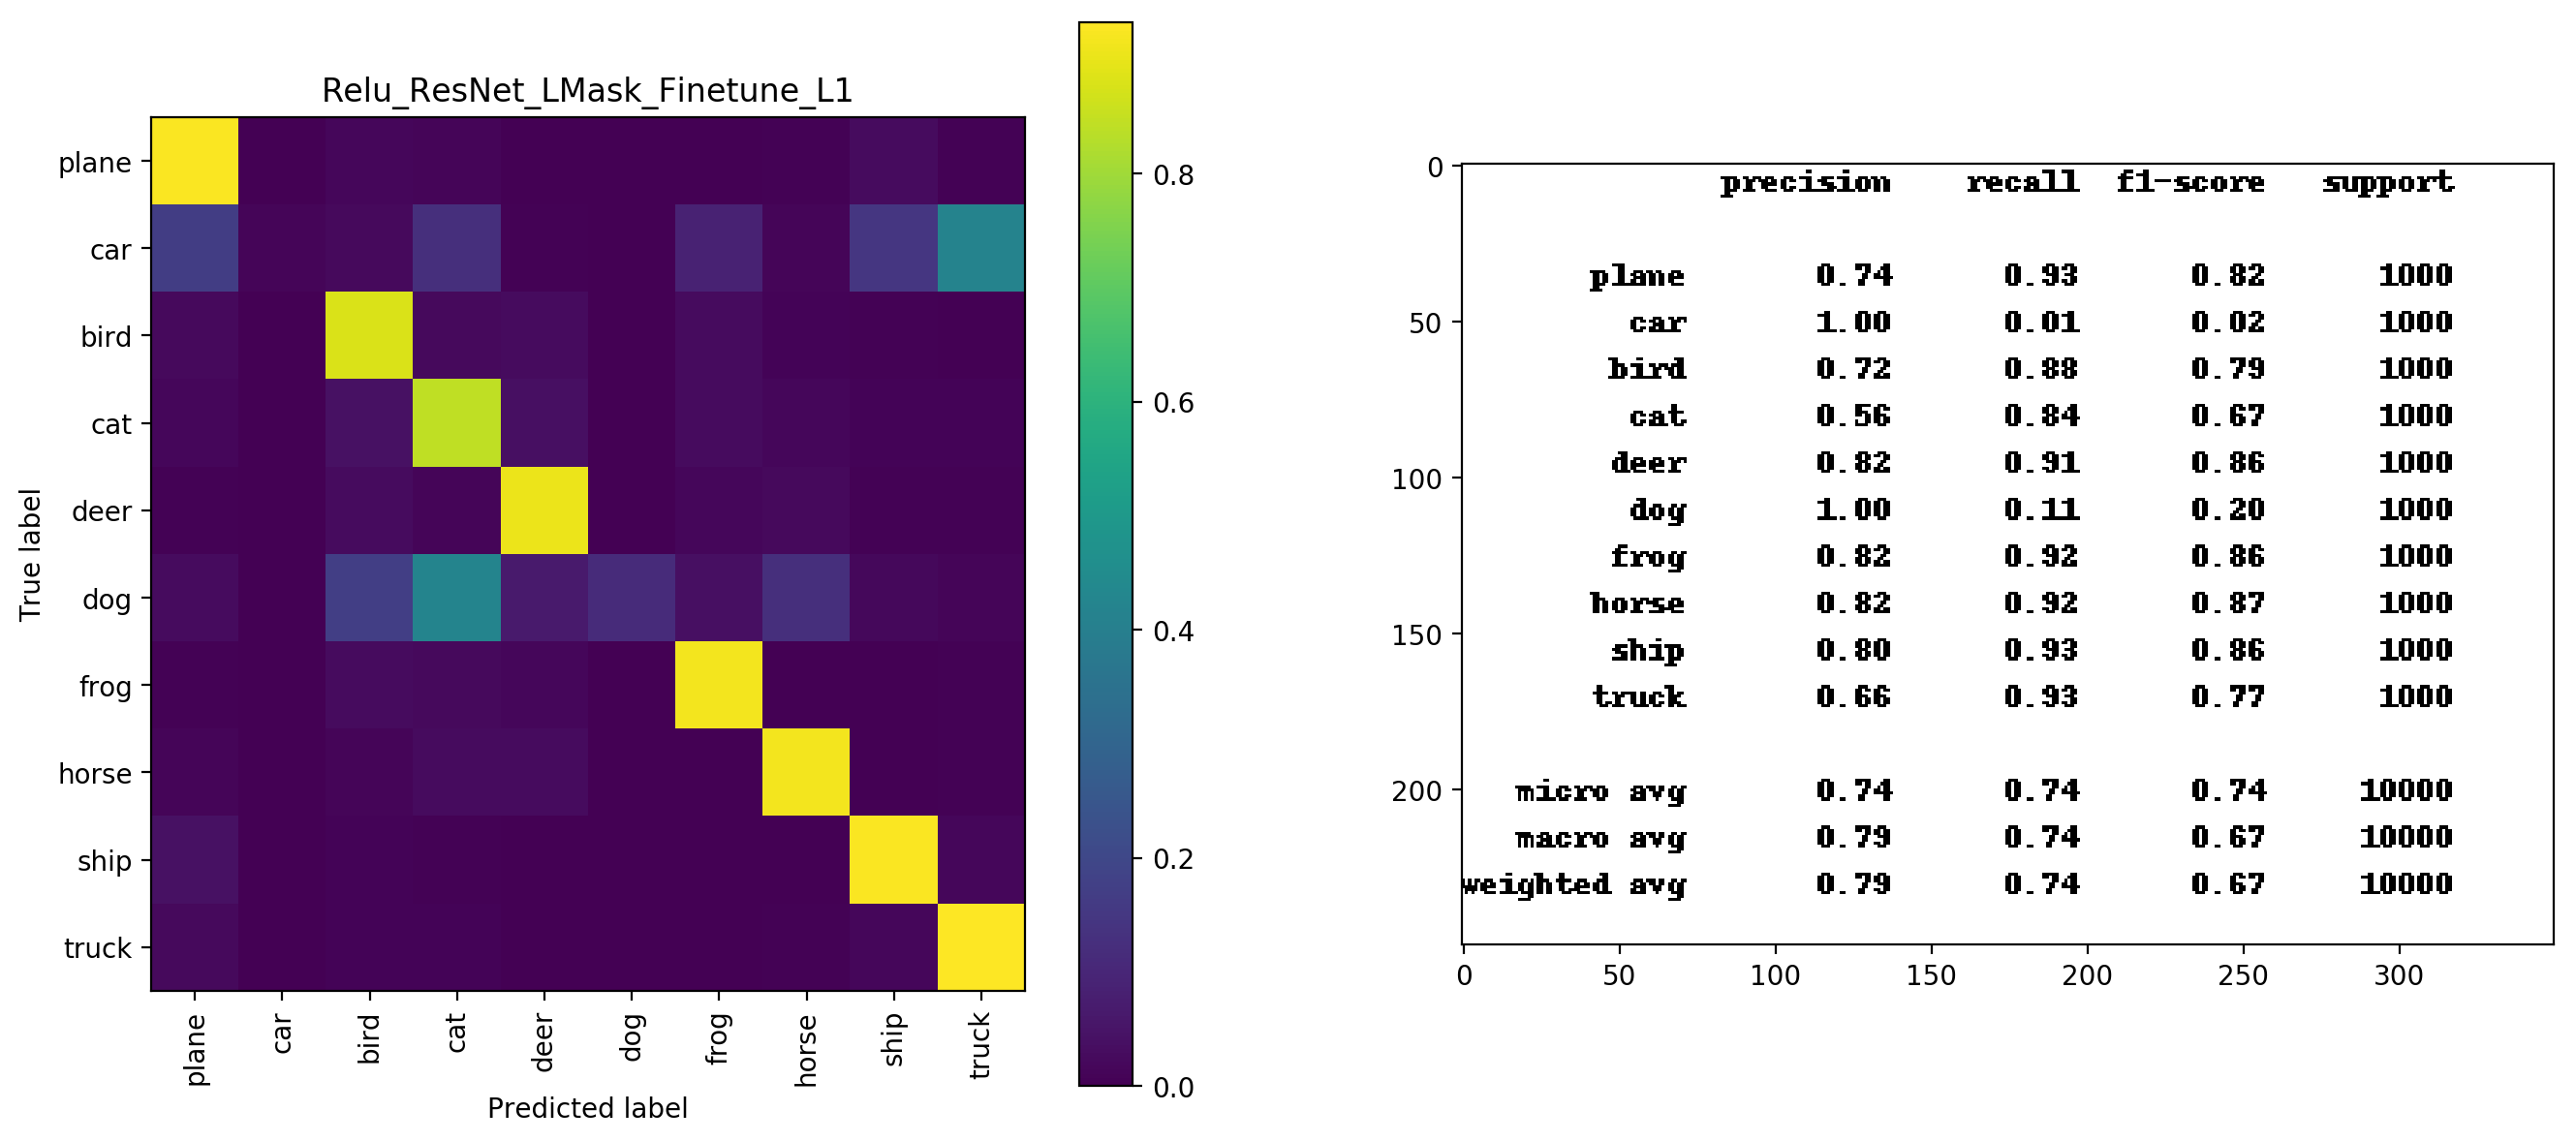

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,929,0,15,12,3,0,2,4,28,7
1,170,12,25,124,6,0,89,11,147,416
2,24,0,880,25,29,0,26,8,6,2
3,15,0,42,842,40,0,28,16,9,8
4,7,0,26,14,905,0,16,24,4,4
5,26,0,172,422,68,114,40,125,19,14
6,6,0,28,22,18,0,916,3,3,4
7,12,0,11,27,27,0,3,916,0,4
8,43,0,8,4,0,0,0,1,926,18
9,24,0,8,10,1,0,2,6,16,933


In [9]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Finetune_L1'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7403
(10, 64)


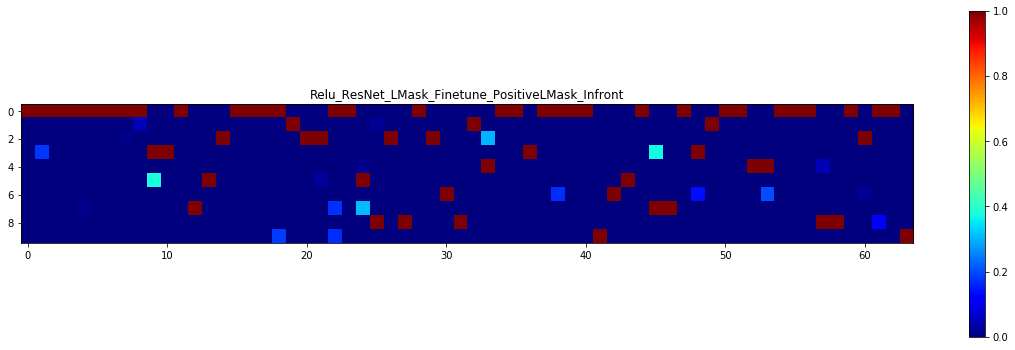

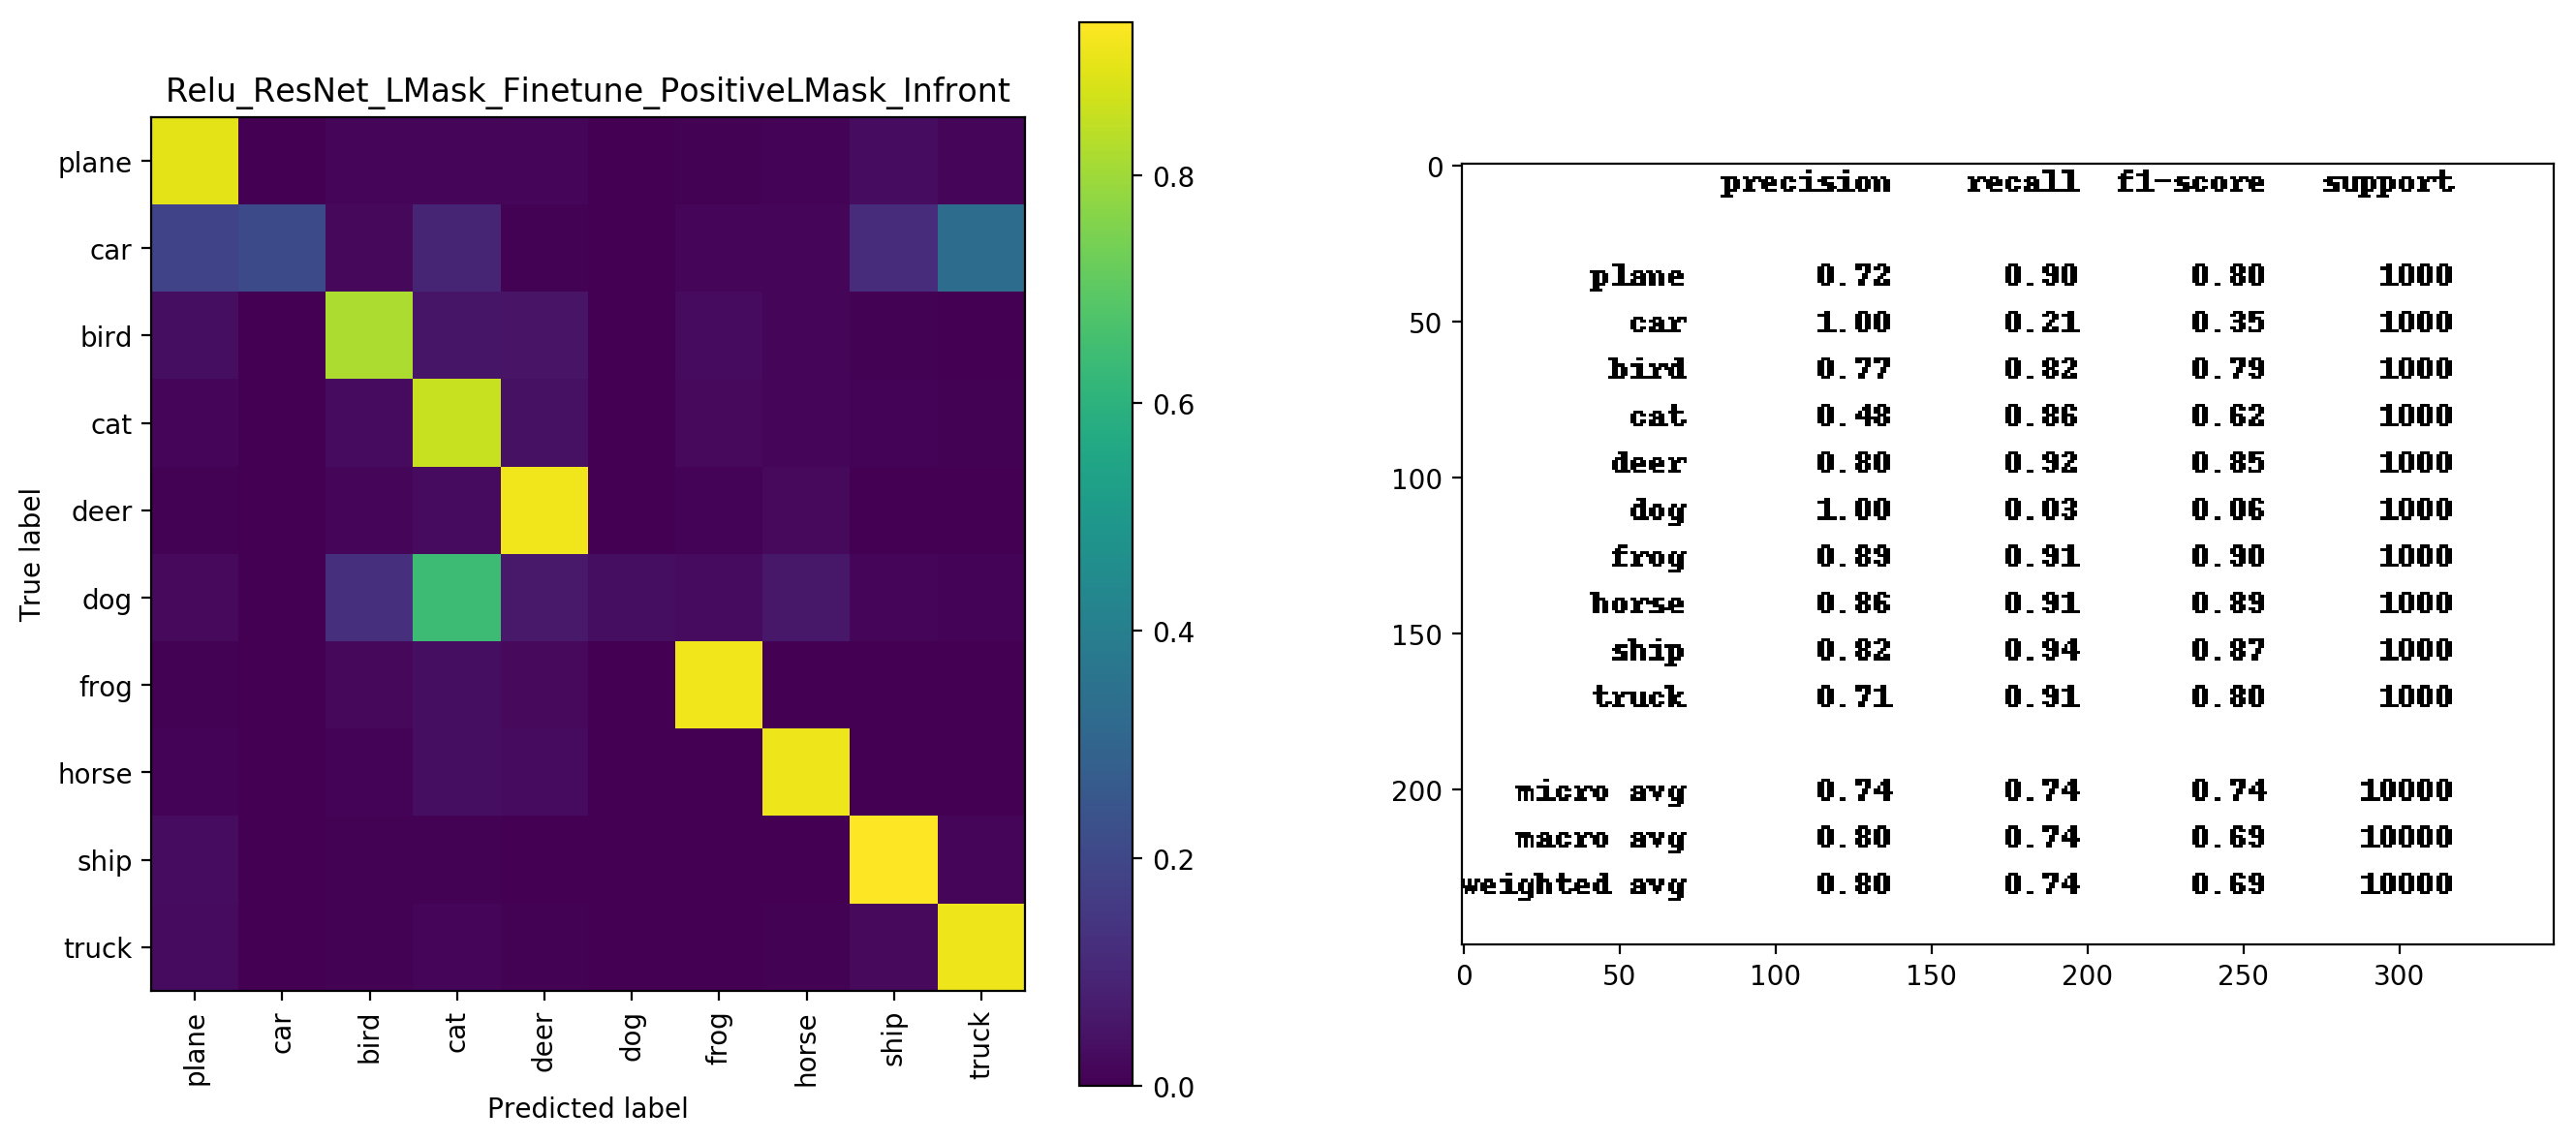

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,895,0,18,15,13,0,6,8,32,13
1,189,209,19,98,6,0,15,15,119,330
2,34,0,819,52,50,0,29,12,4,0
3,15,0,29,858,41,0,25,17,9,6
4,7,0,11,29,916,0,10,24,1,2
5,22,0,128,642,64,33,28,59,14,10
6,6,0,19,34,22,0,914,2,1,2
7,10,0,8,36,27,0,1,913,3,2
8,32,0,7,6,2,0,1,2,935,15
9,29,0,5,15,7,0,3,5,25,911


In [8]:
PATH = "/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Finetune_PositiveLMask_Infront"
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8468
(10, 64)


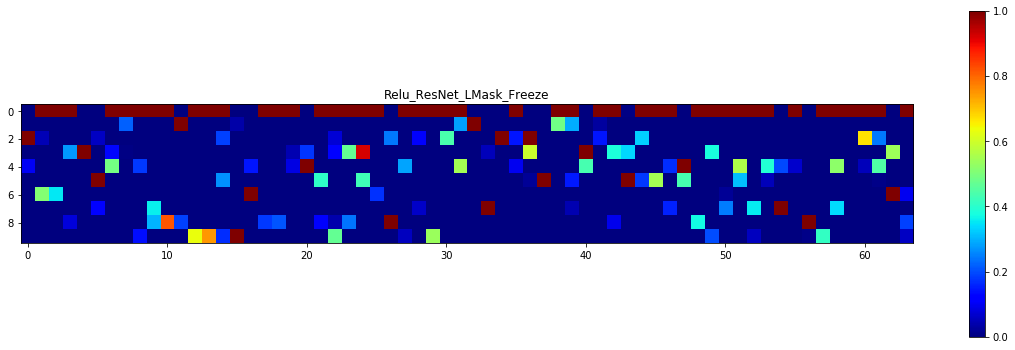

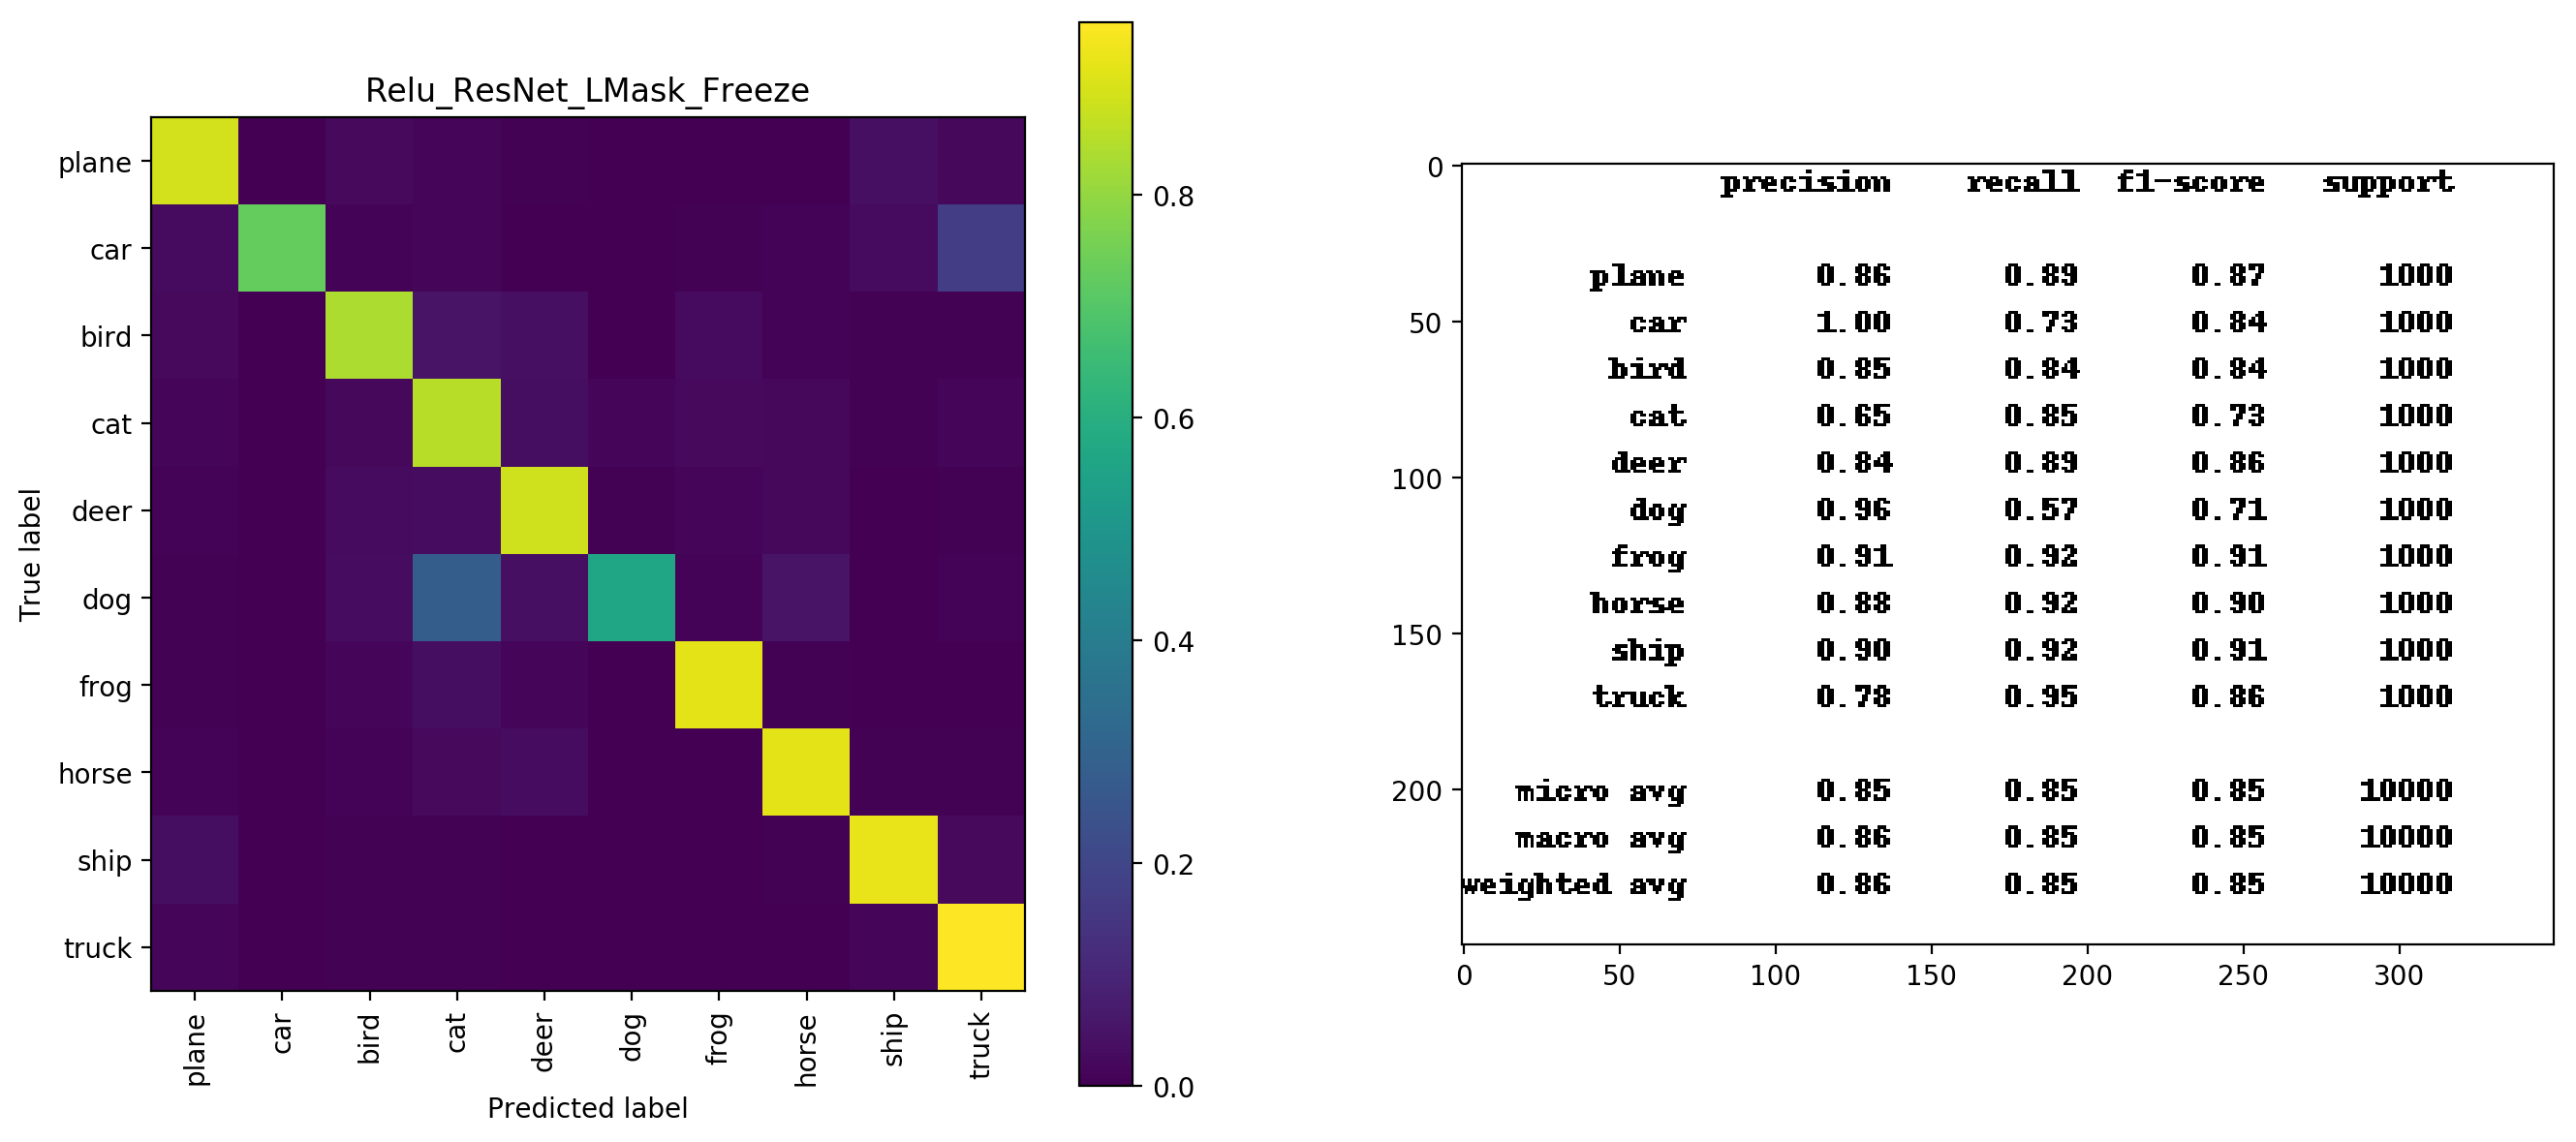

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,891,0,26,14,6,0,1,2,39,21
1,27,730,9,16,1,0,4,9,29,175
2,24,0,836,49,41,2,29,10,4,5
3,16,0,21,851,34,15,23,21,6,13
4,9,0,28,31,886,4,15,20,1,6
5,7,0,30,283,40,566,11,52,2,9
6,6,0,18,37,15,1,915,4,1,3
7,8,0,8,25,31,1,2,916,4,5
8,35,0,5,6,1,0,2,4,922,25
9,18,1,4,5,0,0,0,2,15,955


In [10]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Freeze'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7295
(10, 64)


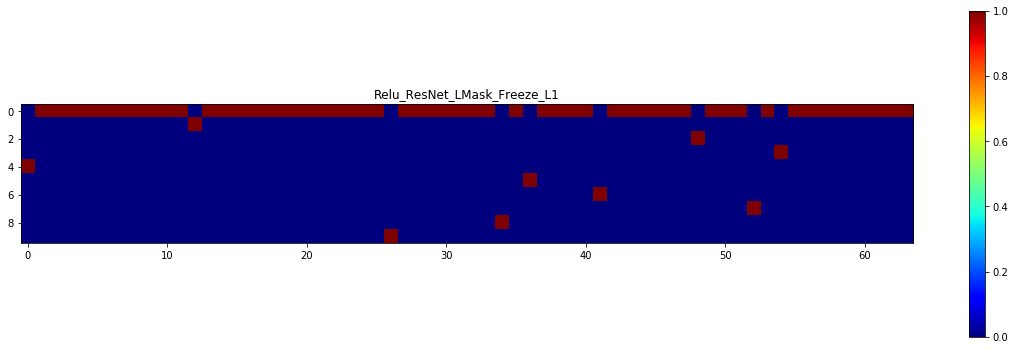

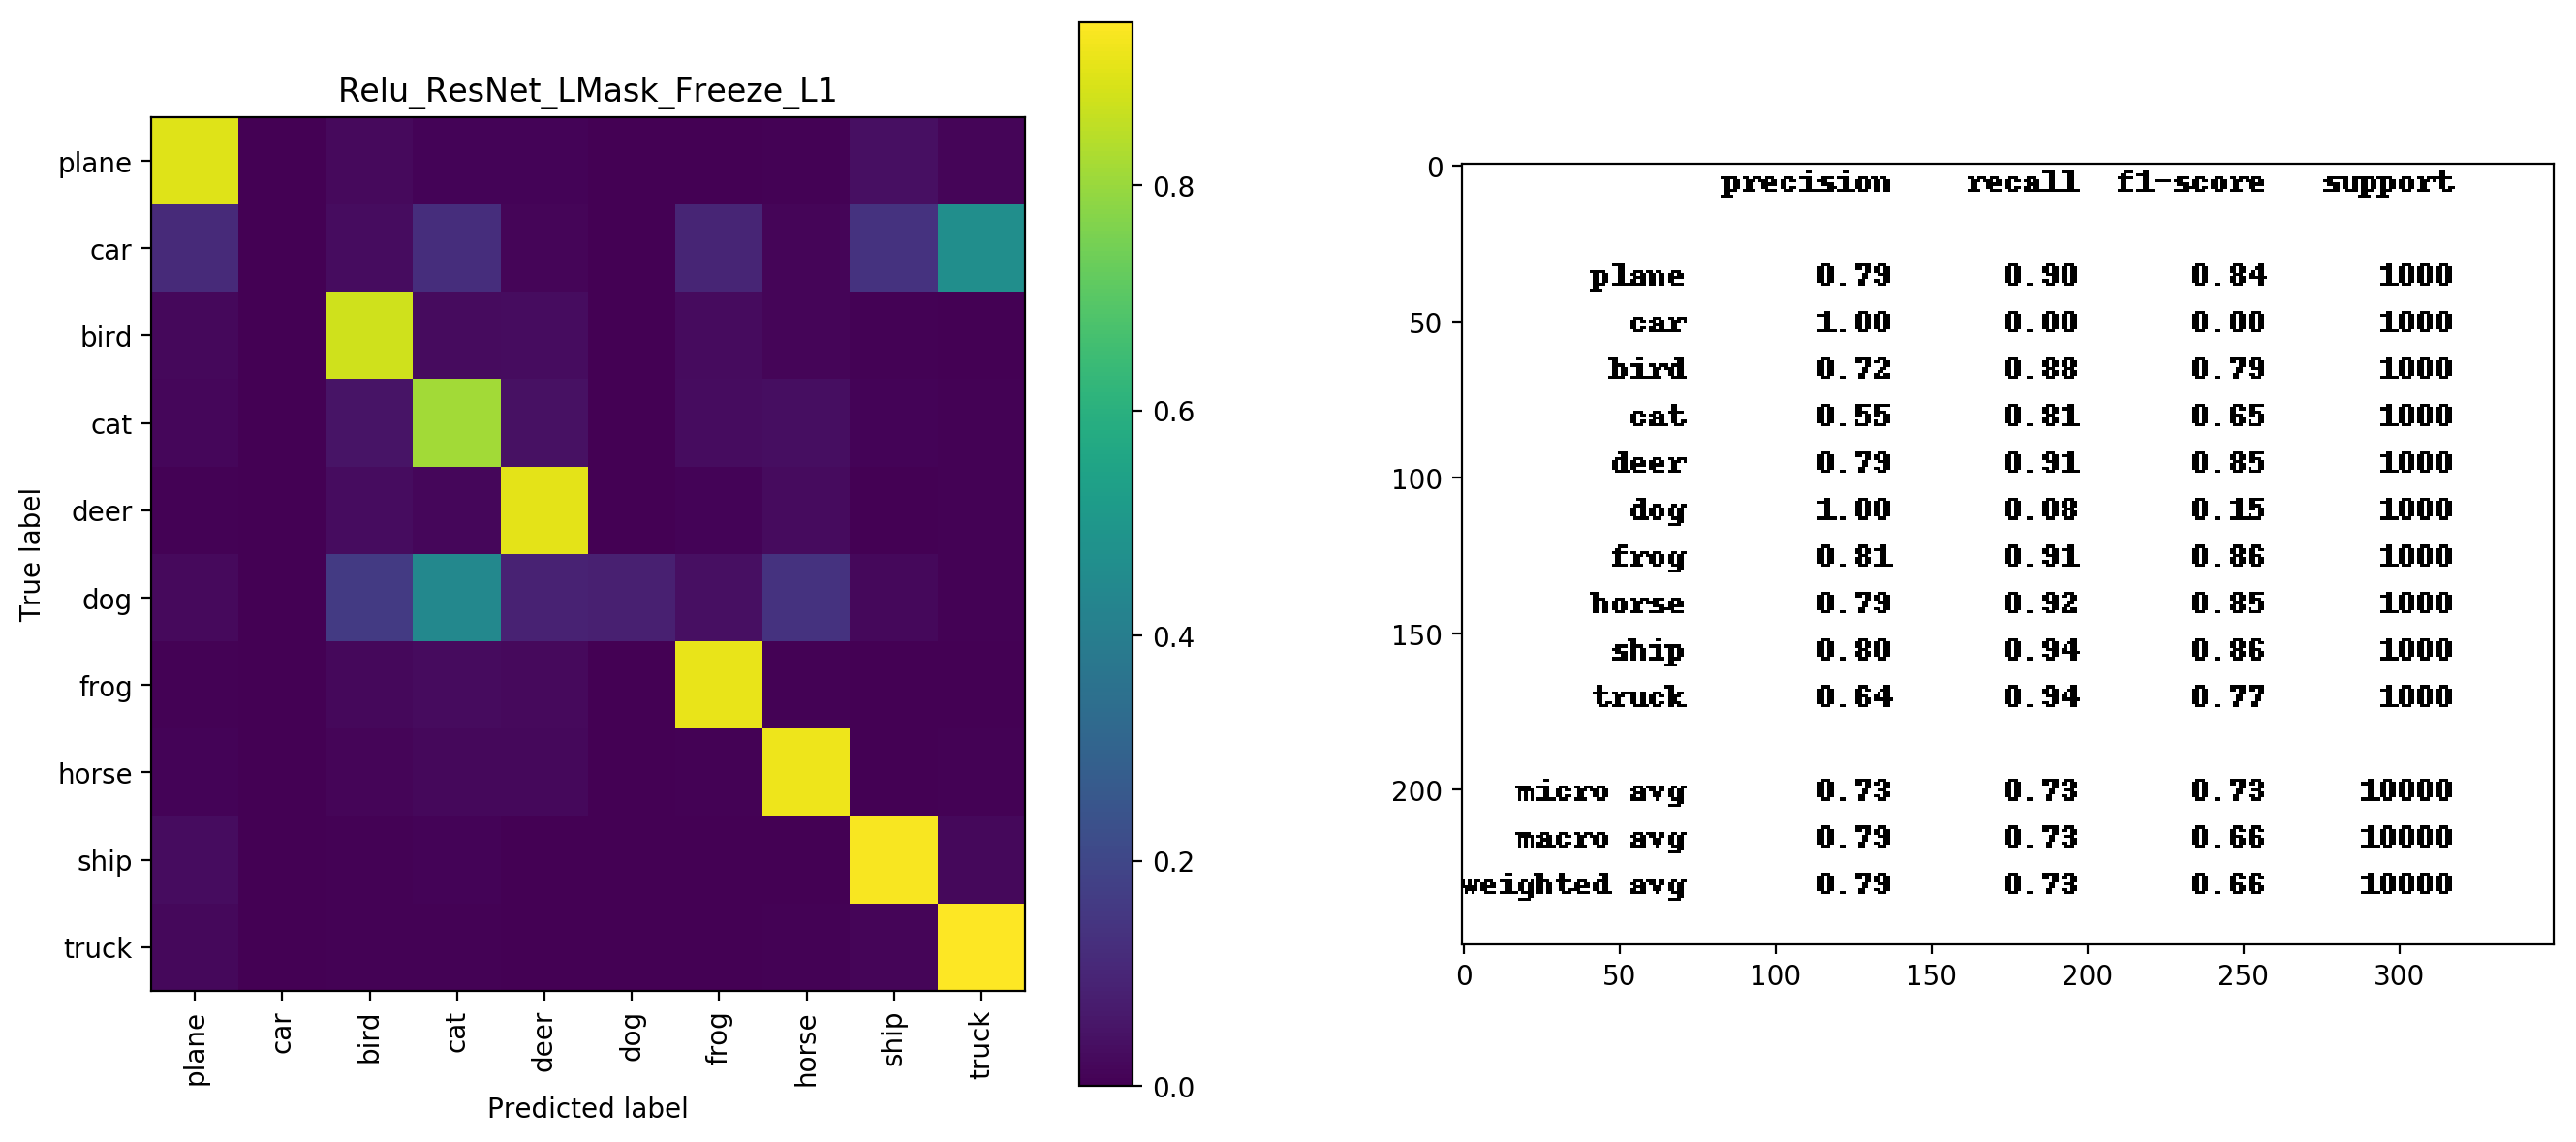

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,899,0,25,8,8,0,3,6,38,13
1,113,1,31,123,14,0,99,13,140,466
2,20,0,875,27,32,0,28,12,5,1
3,15,0,48,815,43,0,31,34,9,5
4,5,0,30,15,907,0,11,26,2,4
5,25,0,160,440,91,83,39,138,19,5
6,5,0,21,27,25,0,913,4,2,3
7,11,0,13,22,22,0,4,922,0,6
8,30,0,4,10,0,0,1,1,935,19
9,22,0,5,5,0,0,3,7,13,945


In [11]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Freeze_L1'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8013
(10, 64)


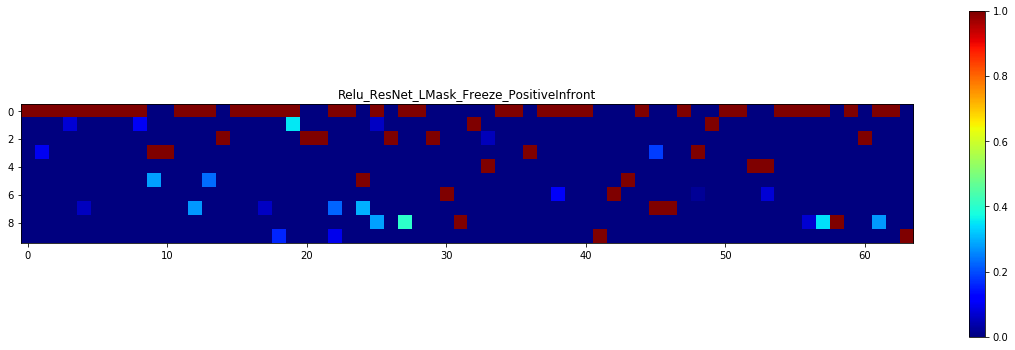

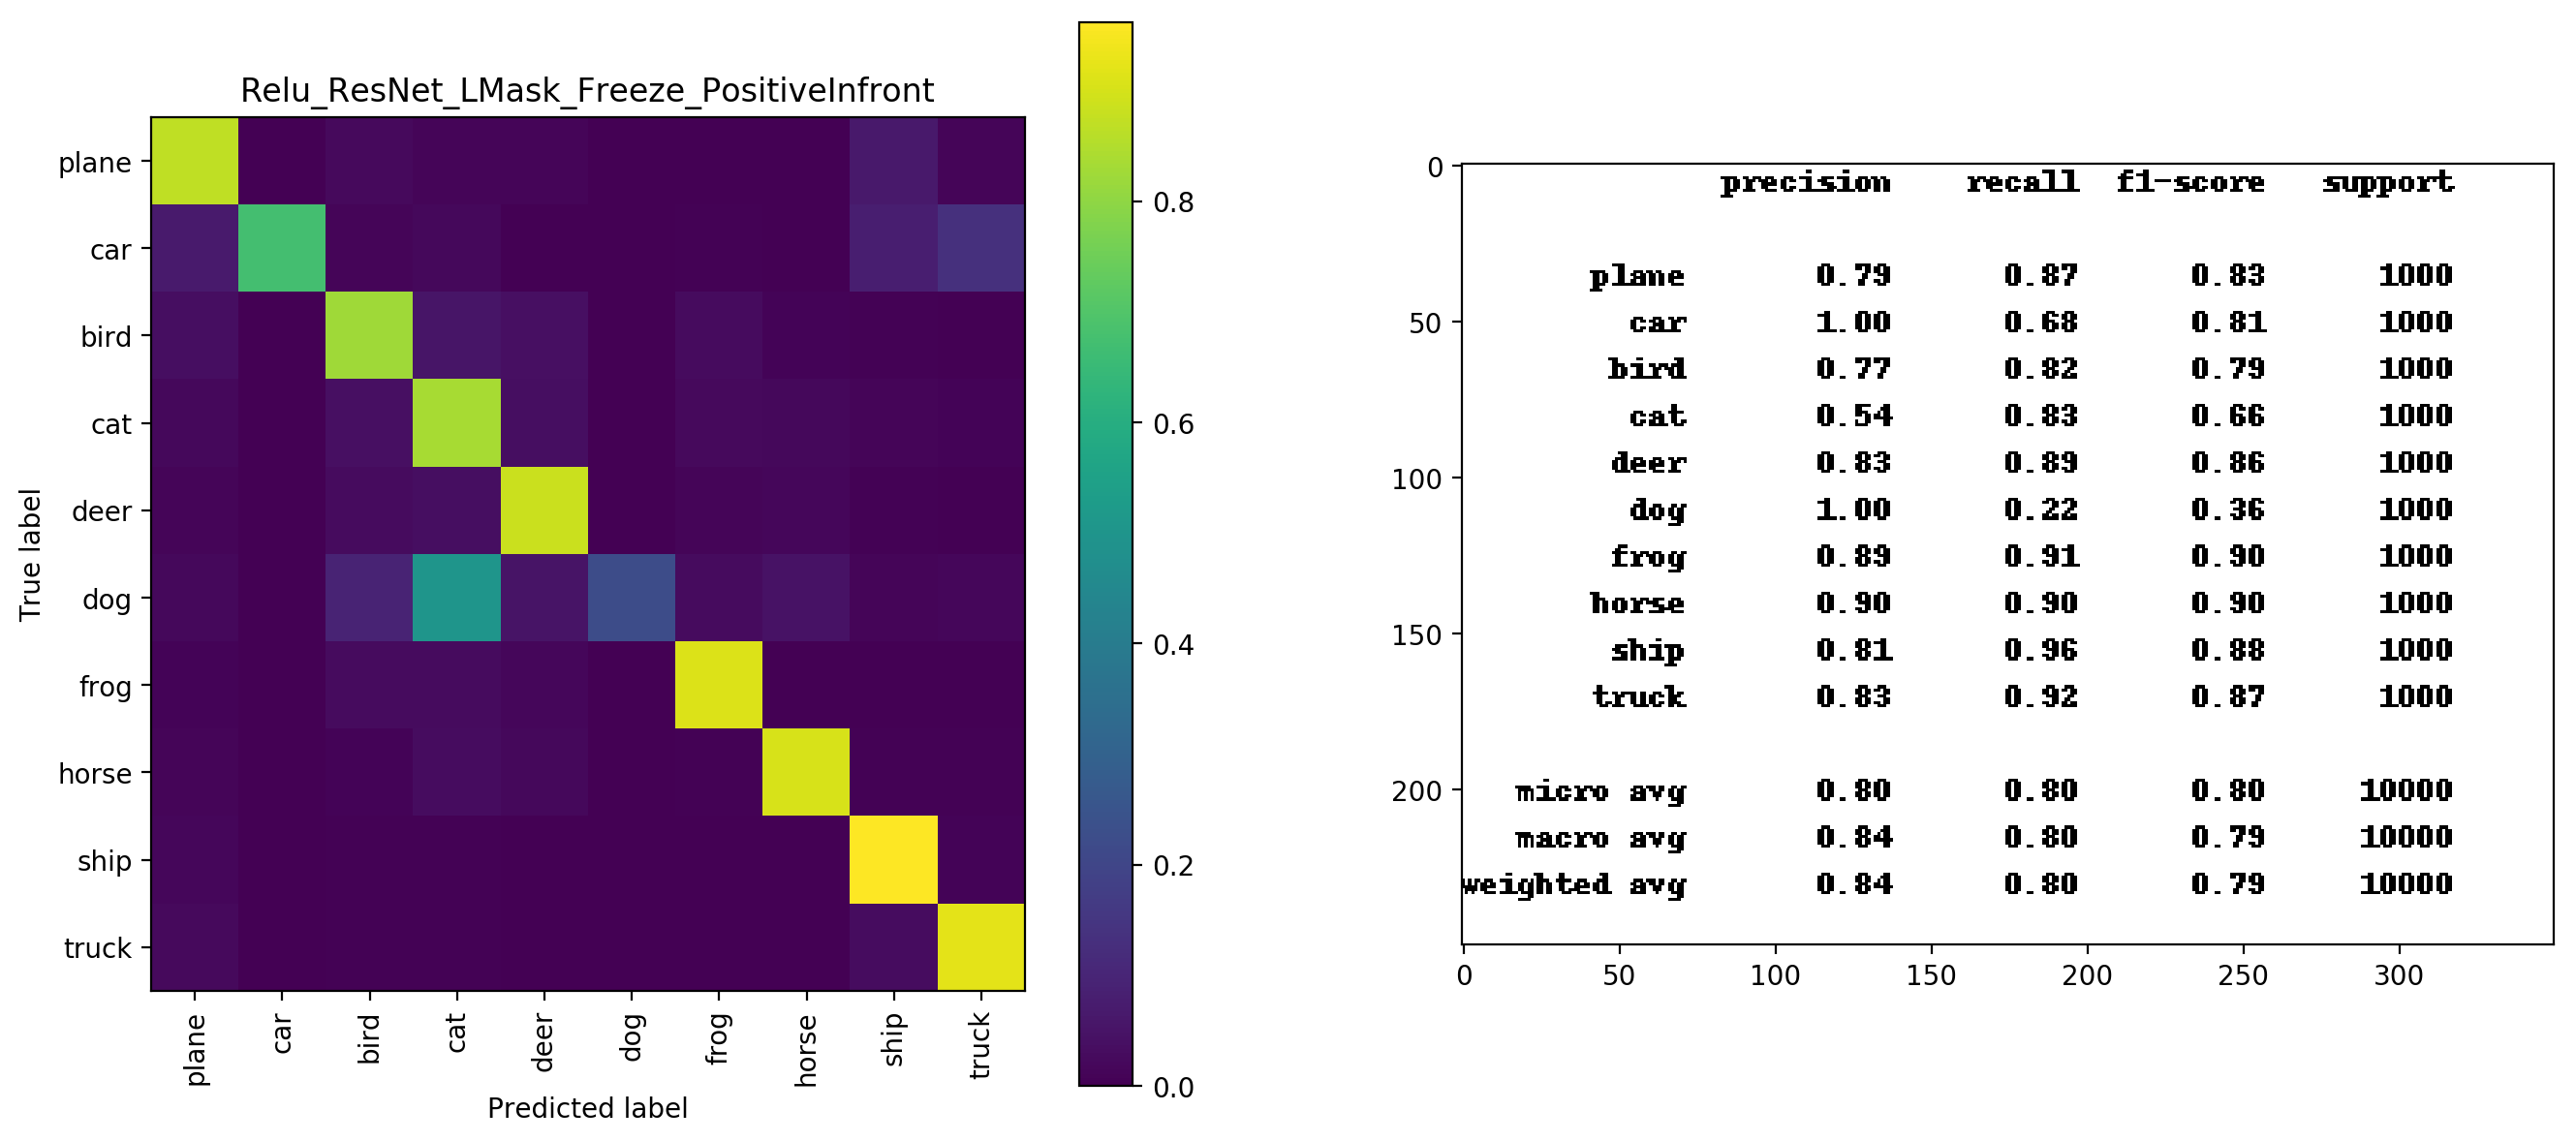

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,869,0,24,14,12,0,1,2,66,12
1,70,676,12,21,1,0,4,3,79,134
2,37,0,824,54,39,0,28,11,7,0
3,22,0,38,835,34,0,25,21,15,10
4,12,0,30,37,886,0,13,16,4,2
5,21,0,97,503,51,223,29,47,13,16
6,8,0,27,30,17,0,911,3,1,3
7,13,0,11,31,22,0,6,904,6,7
8,18,0,5,4,1,0,1,0,962,9
9,25,2,7,7,1,0,1,3,31,923


In [12]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask_Freeze_PositiveInfront'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path, title)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, title)
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table